In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-10-27 17:23:22 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-10-27 17:23:22 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-10-27 17:23:22 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-10-27 17:23:25 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-27 17:23:25 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-27 17:23:25 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-10-27 17:23:25 wandb.docker.auth DEBUG    No config file found


2025-10-27 17:23:26 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-10-27 17:23:26 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-10-27 17:23:26 matplotlib DEBUG    interactive is False
2025-10-27 17:23:26 matplotlib DEBUG    platform is linux
2025-10-27 17:23:26 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-10-27 17:23:26 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-10-27 17:23:26 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-27 17:23:26 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-27 17:23:26 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-10-27 17:23:26 matplotlib.font

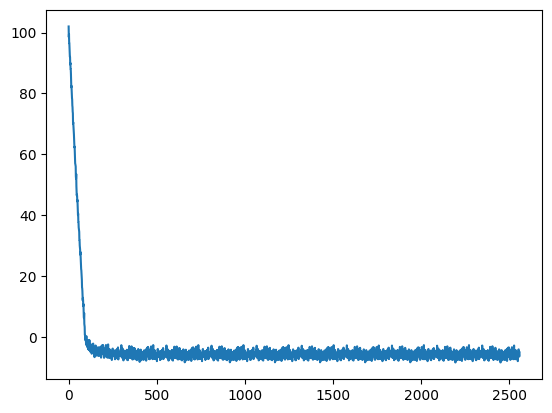

79


(True, True)

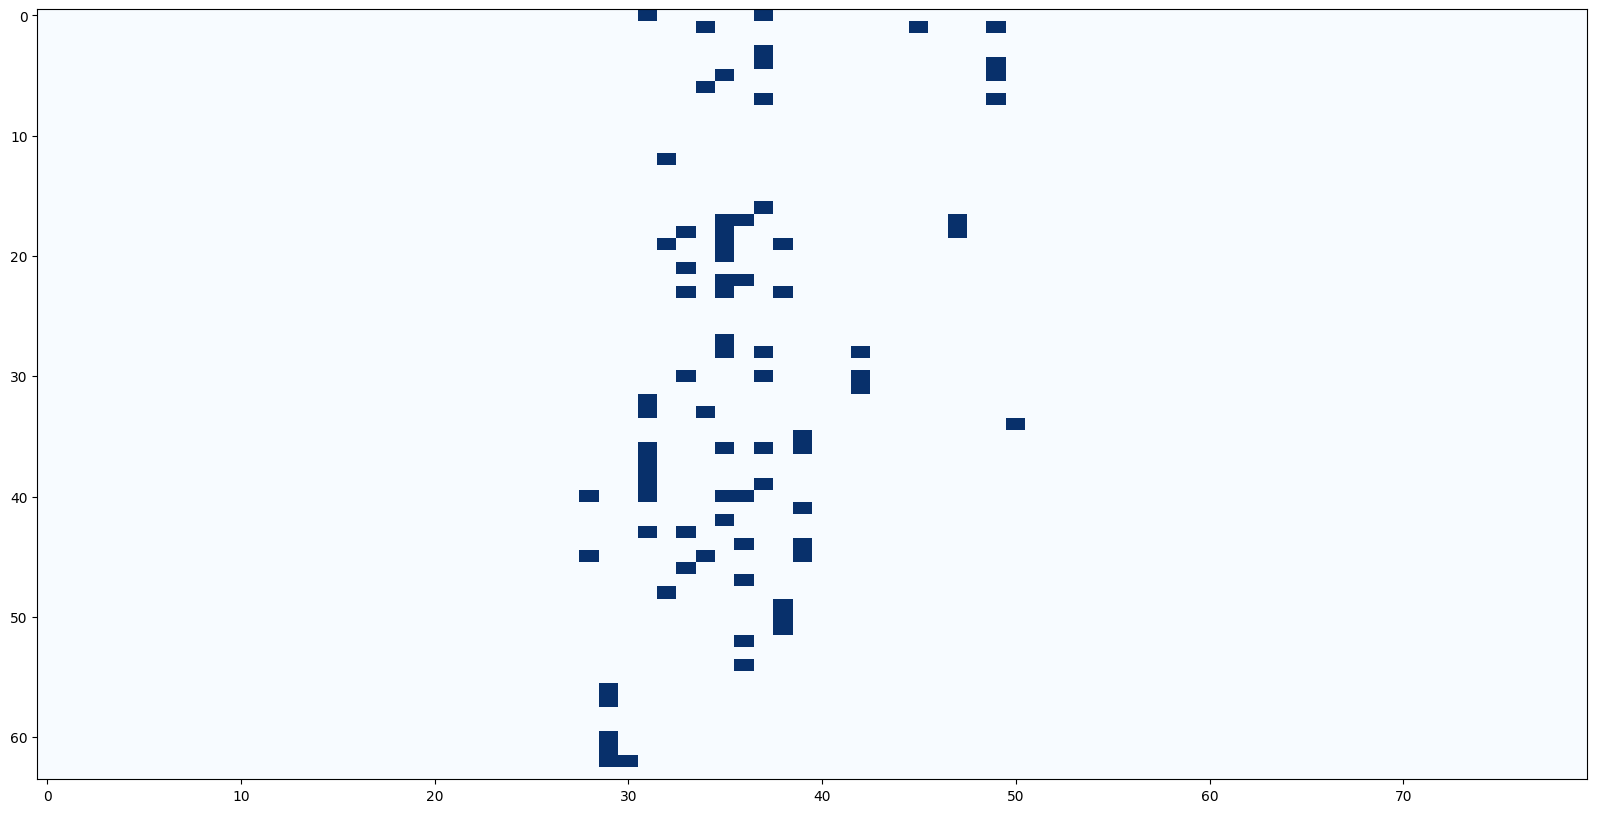

In [4]:
import sys

sys.path.append("../")

from matplotlib import pyplot as plt
import numpy as np
from src.utils import env_utils
import os
import torch

plt.rcdefaults()

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz",
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [(layer_idx, head_idx) for layer_idx, head_idx in optimized_heads]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

## Load LM and the Select Task

In [6]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # torch_dtype=torch.float32,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-10-27 17:23:40 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-10-27 17:23:40 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-10-27 17:23:40 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-10-27 17:23:40 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-10-27 17:23:40 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-10-27 17:24:23 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-10-27 17:24:23 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-10-27 17:24:23 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [7]:
mt.model.layers[15].self_attn.config._attn_implementation

'eager'

In [8]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input
from src.selection.data import get_counterfactual_samples_within_task

from src.selection.data import SelectOneTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR,
        "selection",
        # "profession.json"
        # "nationality.json"
        "objects.json",
    )
)

print(select_task)

source, destination = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    mt=mt,
    task=select_task,
    # patch_category="fruit",
    # clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    
    patch_n_distractors=5,
    clean_n_distractors=5,
    
    distinct_options=False,
    shuffle_clean_options=True,
    mcqify=True
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

print(source.prompt(), ">>", source.obj)
print(destination.prompt(), ">>", destination.obj)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)

2025-10-27 17:24:25 src.selection.data WARNING  Passed clean_n_distractors=5. But distinct_options is False, so clean options will be same as patch options.
2025-10-27 17:24:25 src.selection.data INFO     clean_obj_idx=0 | ['Golf ball', 'Dolphin', 'Laptop', 'Recliner', 'Marker', 'Locket']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-27 17:24:26 src.selection.data INFO     p. Golf ball
q. Dolphin
r. Locket
s. Marker
t. Recliner
u. Lapto

In [9]:
from src.functional import generate_with_patch
from src.selection.functional import verify_head_patterns

print(destination.prompt(), ">>", destination.obj)
print(source.prompt(), ">>", source.obj)

gold_sample = copy.deepcopy(source)
gold_sample.option_label_start_from = destination.option_label_start_from
gold_sample.options = copy.deepcopy(destination.options)

layer_idx, head_idx = (35, 19)

for sample in [source, destination, gold_sample]:
    print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        mt=mt,
        heads=[(35, 19)],
        query_index=-1,
    )

a. Golf ball
b. Dolphin
c. Laptop
d. Recliner
e. Marker
f. Locket
Which among these objects mentioned above is a sport equipment?
Answer: >> Golf ball
p. Golf ball
q. Dolphin
r. Locket
s. Marker
t. Recliner
u. Laptop
Which among these objects mentioned above is a jewelry?
Answer: >> Locket
p. Golf ball
q. Dolphin
r. Locket
s. Marker
t. Recliner
u. Laptop
Which among these objects mentioned above is a jewelry?
Answer: >> " r"
2025-10-27 17:24:27 src.selection.functional DEBUG    Predictions: ['" r"[436] (p=0.883, logit=22.250)', '" ("[320] (p=0.027, logit=18.750)', '" Option"[7104] (p=0.023, logit=18.625)', '" A"[362] (p=0.014, logit=18.125)', '" The"[578] (p=0.011, logit=17.875)']
2025-10-27 17:24:27 src.selection.functional INFO     Combined attention matrix for all heads


a. Golf ball
b. Dolphin
c. Laptop
d. Recliner
e. Marker
f. Locket
Which among these objects mentioned above is a sport equipment?
Answer: >> " a"
2025-10-27 17:24:27 src.selection.functional DEBUG    Predictions: ['" a"[264] (p=0.805, logit=22.750)', '" ("[320] (p=0.066, logit=20.250)', '" Golf"[28131] (p=0.045, logit=19.875)', '" The"[578] (p=0.035, logit=19.625)', '" Option"[7104] (p=0.017, logit=18.875)']
2025-10-27 17:24:27 src.selection.functional INFO     Combined attention matrix for all heads


a. Golf ball
b. Dolphin
c. Laptop
d. Recliner
e. Marker
f. Locket
Which among these objects mentioned above is a jewelry?
Answer: >> " r"
2025-10-27 17:24:27 src.selection.functional DEBUG    Predictions: ['" f"[282] (p=0.750, logit=22.500)', '" ("[320] (p=0.148, logit=20.875)', '" The"[578] (p=0.029, logit=19.250)', '" A"[362] (p=0.018, logit=18.750)', '" L"[445] (p=0.007, logit=17.750)']
2025-10-27 17:24:27 src.selection.functional INFO     Combined attention matrix for all heads


## Debug OV Patching Code

In [10]:
from src.utils.typing import TokenizerOutput

source_tokenized = prepare_input(
    prompts=[
        source.prompt(), 
        destination.prompt()
    ], tokenizer=mt
)
destination_tokenized = prepare_input(
    prompts=[
        destination.prompt(), 
        source.prompt()
    ], tokenizer=mt
)

In [11]:
t = torch.randn(3, 4)
type(t[0][0]) is torch.Tensor

True

In [12]:
from typing import Optional
from typing import Callable
from src.hooking.llama_attention import apply_rotary_pos_emb, repeat_kv
import types

mt.set_attn_implementation("eager")
def eager_attention_forward(
    module: torch.nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    scaling: float,
    dropout: float = 0.0,
    **kwargs,
):
    key_states = repeat_kv(key, module.num_key_value_groups)
    value_states = repeat_kv(value, module.num_key_value_groups)

    attn_weights = torch.matmul(query, key_states.transpose(2, 3)) * scaling
    if attention_mask is not None:
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query.dtype)
    attn_weights = torch.nn.functional.dropout(attn_weights, p=dropout, training=module.training)
    attn_output = torch.matmul(attn_weights, value_states)
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, attn_weights


def attn_per_head(
    o_proj: torch.nn.modules.linear.Linear,
    attn_output: torch.Tensor,
    set_attn_contributions: dict[int, tuple[float, dict[int, torch.Tensor]]] = {}, # head_idx -> token_idx -> (mask, ov_contribution)
):
    # print(attn_output.size())
    b, q_len, n_head, h_dim = attn_output.size()
    o_proj_weight_split = o_proj.weight.view(o_proj.out_features, n_head, h_dim)

    # print(f"{o_proj_weight_split.size()=}")
    # print(f"{attn_output.size()=}")

    per_head_contributions = []
    for head_idx in range(n_head):
        # calculate the contribution per head
        attn_output_per_head = attn_output[
            :, :, head_idx, :
        ]  # shape: (b, q_len, h_dim)
        attn_output_per_head = attn_output_per_head.to(
            o_proj_weight_split[:, head_idx, :].dtype
        ).to(o_proj_weight_split[:, head_idx, :].device)
        projected_per_head = (
            attn_output_per_head @ o_proj_weight_split[:, head_idx, :].T
        )  # shape: (b, q_len, out_features)

        # *Patch the contributions if specified
        if head_idx in set_attn_contributions:
            mask = set_attn_contributions[head_idx][0]
            for token_idx, ov_contribution in set_attn_contributions[head_idx][1].items():
                # print(f"Patching head {head_idx} token {token_idx}")
                orig = projected_per_head[:, token_idx, :].clone().detach()
                device = orig.device
                mask = mask.to(device) if isinstance(mask, torch.Tensor) else mask
                ov_contribution = ov_contribution.to(device)
                patch = mask * ov_contribution + (1 - mask) * orig

                projected_per_head[:, token_idx, :] = patch.to(
                    orig.dtype
                ).to(orig.device)

        per_head_contributions.append(projected_per_head)
        # print(f"{projected_per_head.size()=}")

    per_head_contributions = torch.stack(
        per_head_contributions, dim=1
    )  # shape: (b, n_head, q_len, out_features)

    attn_output = per_head_contributions.sum(dim=1)  # shape: (b, q_len, out_features)

    # print(f"{attn_output.size()=} | {per_head_contributions.size()=}")
    return attn_output, per_head_contributions


def attn_forward_with_custom_attn_pattern(
    block_name: str | None = None,
    set_attn_contributions: dict[int, tuple[float, dict[int, torch.Tensor]]] = {}, # head_idx -> token_idx -> (mask, ov_contribution)
    get_attn_contributions: list[tuple[int, int]] = [],  # list of (head_idx, token_idx)
    cache_attn_contributions: dict[tuple[int], dict[int, torch.Tensor]] = {}, # head_idx -> token_idx -> ov_contribution
):
    def forward_modified(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_values = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if past_key_values is not None:
            # sin and cos are specific to RoPE models; cache_position needed for the static cache
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_values.update(key_states, value_states, self.layer_idx, cache_kwargs)

        attention_interface: Callable = eager_attention_forward
        if self.config._attn_implementation != "eager":
            assert False, "Not implemented yet!"
            # attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]

        if block_name is not None:
            # only for debugging
            print(f"{block_name}")

        attn_output, attn_weights = attention_interface(
            self,
            query_states,
            key_states,
            value_states,
            attention_mask,
            dropout=0.0 if not self.training else self.attention_dropout,
            scaling=self.scaling,
            **kwargs,
        )

        if len(set_attn_contributions) > 0 or len(get_attn_contributions) > 0:
            __attn_output, per_head_contributions = attn_per_head(
                self.o_proj,
                attn_output,
                set_attn_contributions=set_attn_contributions,
            )

            # print(f"{__attn_output.size()=} | {per_head_contributions.size()=}")

            if len(get_attn_contributions) > 0:
                for head_idx, token_idx in get_attn_contributions:
                    if head_idx not in cache_attn_contributions:
                        cache_attn_contributions[head_idx] = {}
                    cache_attn_contributions[head_idx][token_idx] = per_head_contributions[
                        :, head_idx, token_idx, :
                    ]

        if len(set_attn_contributions) > 0:
            attn_output = __attn_output
        else:
            #* clean implementation
            attn_output = attn_output.reshape(*input_shape, -1).contiguous()
            attn_output = self.o_proj(attn_output)

        # print(f"{attn_output.size()=}, {attn_weights.size()=}")

        return attn_output, attn_weights
    
    return forward_modified

# mt.reset_forward()
# for layer_idx in range(mt.config.num_hidden_layers):
#     attn_block_name = mt.attn_module_name_format.format(layer_idx)
#     attn_block = baukit.get_module(mt._model, attn_block_name)
#     attn_block.forward = types.MethodType(attn_forward_with_custom_attn_pattern(), attn_block)

In [13]:
from src.functional import get_module_nnsight, interpret_logits, free_gpu_cache
from itertools import product

####################################################
query_mapping = {-1: -1}
# heads = [(35, 19)]
heads = optimized_heads
####################################################

free_gpu_cache()
heads_per_layer = {}
for layer_idx, head_idx in heads:
    if layer_idx not in heads_per_layer:
        heads_per_layer[layer_idx] = []
    heads_per_layer[layer_idx].append(head_idx)

source_ov_contributions = {}

mt.reset_forward()
for layer_idx in heads_per_layer.keys():
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = get_module_nnsight(mt._model, attn_block_name)
    source_ov_contributions[layer_idx] = {}
    attn_block.forward = types.MethodType(
        attn_forward_with_custom_attn_pattern(
            # block_name=attn_block_name,
            set_attn_contributions={},
            get_attn_contributions=list(product(
                heads_per_layer[layer_idx],
                query_mapping.keys(), # source_token_indices
            )),
            cache_attn_contributions=source_ov_contributions[layer_idx],
        ),
        attn_block,
    )

source_outputs = mt._model(**source_tokenized)
mt.reset_forward()

logits = source_outputs.logits[:, -1, :]
logger.debug(f"{logits.size()=}")

for layer_idx, head_idx in heads:
    logger.debug(
        f"L{layer_idx} H{head_idx}: {source_ov_contributions[layer_idx][head_idx][-1].size()}"
    )

interpret_logits(
    logits=logits[0],
    tokenizer=mt.tokenizer,
    k=15,
)

2025-10-27 17:24:33 __main__ DEBUG    logits.size()=torch.Size([2, 128256])
2025-10-27 17:24:33 __main__ DEBUG    L28 H40: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L28 H45: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L29 H56: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L29 H57: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L29 H60: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L29 H61: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L29 H62: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L30 H62: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L31 H0: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L31 H32: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L31 H33: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L31 H36: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__ DEBUG    L31 H37: torch.Size([2, 8192])
2025-10-27 17:24:33 __main__

[PredictedToken(token=' r', prob=0.875, logit=22.125, token_id=436, metadata=None),
 PredictedToken(token=' (', prob=0.0299072265625, logit=18.75, token_id=320, metadata=None),
 PredictedToken(token=' Option', prob=0.0233154296875, logit=18.5, token_id=7104, metadata=None),
 PredictedToken(token=' A', prob=0.0159912109375, logit=18.125, token_id=362, metadata=None),
 PredictedToken(token=' The', prob=0.010986328125, logit=17.75, token_id=578, metadata=None),
 PredictedToken(token=' Among', prob=0.007568359375, logit=17.375, token_id=22395, metadata=None),
 PredictedToken(token=' R', prob=0.00518798828125, logit=17.0, token_id=432, metadata=None),
 PredictedToken(token=' p', prob=0.00457763671875, logit=16.875, token_id=281, metadata=None),
 PredictedToken(token=' L', prob=0.00457763671875, logit=16.875, token_id=445, metadata=None),
 PredictedToken(token=' lo', prob=0.003570556640625, logit=16.625, token_id=781, metadata=None),
 PredictedToken(token=' option', prob=0.00179290771484375,

In [14]:
free_gpu_cache()

In [15]:
mt.reset_forward()

destination_ov_contributions = {}

for layer_idx in heads_per_layer.keys():
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = get_module_nnsight(mt._model, attn_block_name)
    destination_ov_contributions[layer_idx] = {}
    attn_block.forward = types.MethodType(
        attn_forward_with_custom_attn_pattern(
            # block_name=attn_block_name,
            set_attn_contributions={head_idx: (1.0, source_ov_contributions[layer_idx][head_idx]) for head_idx in heads_per_layer[layer_idx]},
            get_attn_contributions=list(product(
                heads_per_layer[layer_idx],
                query_mapping.values(), # destination_token_indices
            )),
            cache_attn_contributions=destination_ov_contributions[layer_idx],
        ),
        attn_block,
    )

patched_outputs = mt._model(**destination_tokenized)
mt.reset_forward()

logits = patched_outputs.logits[:, -1, :]
logger.debug(f"{logits.size()=}")
interpret_logits(
    logits=logits[0],
    tokenizer=mt.tokenizer,
    k=15,
)

2025-10-27 17:24:35 __main__ DEBUG    logits.size()=torch.Size([2, 128256])


[PredictedToken(token=' f', prob=0.4921875, logit=21.25, token_id=282, metadata=None),
 PredictedToken(token=' (', prob=0.205078125, logit=20.375, token_id=320, metadata=None),
 PredictedToken(token=' Option', prob=0.06640625, logit=19.25, token_id=7104, metadata=None),
 PredictedToken(token=' Re', prob=0.06640625, logit=19.25, token_id=1050, metadata=None),
 PredictedToken(token=' The', prob=0.040283203125, logit=18.75, token_id=578, metadata=None),
 PredictedToken(token=' e', prob=0.01904296875, logit=18.0, token_id=384, metadata=None),
 PredictedToken(token=' Among', prob=0.016845703125, logit=17.875, token_id=22395, metadata=None),
 PredictedToken(token=' Letter', prob=0.01483154296875, logit=17.75, token_id=27757, metadata=None),
 PredictedToken(token=' A', prob=0.01312255859375, logit=17.625, token_id=362, metadata=None),
 PredictedToken(token=' option', prob=0.0079345703125, logit=17.125, token_id=3072, metadata=None),
 PredictedToken(token=' It', prob=0.005462646484375, logit=1

In [16]:
for layer_idx, head_idx in heads:
    logger.debug(
        f"L{layer_idx} H{head_idx}: {torch.allclose(source_ov_contributions[layer_idx][head_idx][-1], destination_ov_contributions[layer_idx][head_idx][-1])}"
    )

2025-10-27 17:24:35 __main__ DEBUG    L28 H40: True
2025-10-27 17:24:35 __main__ DEBUG    L28 H45: True
2025-10-27 17:24:35 __main__ DEBUG    L29 H56: True
2025-10-27 17:24:35 __main__ DEBUG    L29 H57: True
2025-10-27 17:24:35 __main__ DEBUG    L29 H60: True
2025-10-27 17:24:35 __main__ DEBUG    L29 H61: True
2025-10-27 17:24:35 __main__ DEBUG    L29 H62: True
2025-10-27 17:24:35 __main__ DEBUG    L30 H62: True
2025-10-27 17:24:35 __main__ DEBUG    L31 H0: True
2025-10-27 17:24:35 __main__ DEBUG    L31 H32: True
2025-10-27 17:24:35 __main__ DEBUG    L31 H33: True
2025-10-27 17:24:35 __main__ DEBUG    L31 H36: True
2025-10-27 17:24:35 __main__ DEBUG    L31 H37: True
2025-10-27 17:24:35 __main__ DEBUG    L31 H38: True
2025-10-27 17:24:35 __main__ DEBUG    L31 H39: True
2025-10-27 17:24:35 __main__ DEBUG    L31 H40: True
2025-10-27 17:24:35 __main__ DEBUG    L31 H43: True
2025-10-27 17:24:35 __main__ DEBUG    L32 H12: True


2025-10-27 17:24:35 __main__ DEBUG    L32 H19: True
2025-10-27 17:24:35 __main__ DEBUG    L32 H48: True
2025-10-27 17:24:35 __main__ DEBUG    L33 H18: True
2025-10-27 17:24:35 __main__ DEBUG    L33 H21: True
2025-10-27 17:24:35 __main__ DEBUG    L33 H23: True
2025-10-27 17:24:35 __main__ DEBUG    L33 H30: True
2025-10-27 17:24:35 __main__ DEBUG    L33 H43: True
2025-10-27 17:24:35 __main__ DEBUG    L33 H46: True
2025-10-27 17:24:35 __main__ DEBUG    L34 H1: True
2025-10-27 17:24:35 __main__ DEBUG    L34 H6: True
2025-10-27 17:24:35 __main__ DEBUG    L34 H33: True
2025-10-27 17:24:35 __main__ DEBUG    L34 H45: True
2025-10-27 17:24:35 __main__ DEBUG    L35 H5: True
2025-10-27 17:24:35 __main__ DEBUG    L35 H17: True
2025-10-27 17:24:35 __main__ DEBUG    L35 H18: True
2025-10-27 17:24:35 __main__ DEBUG    L35 H19: True
2025-10-27 17:24:35 __main__ DEBUG    L35 H20: True
2025-10-27 17:24:35 __main__ DEBUG    L35 H22: True
2025-10-27 17:24:35 __main__ DEBUG    L35 H23: True
2025-10-27 17:2

In [17]:
from src.utils.typing import SVD
from src.attention import visualize_attn_matrix

def get_ov_contributions(
    mt: ModelandTokenizer,
    sample_tokenized: TokenizerOutput,
    heads_per_layer: dict[int, list[int]],
    query_indices: list[int],
    model_kwargs: dict = {},
):
    ov_contributions = {}

    mt.reset_forward()
    for layer_idx in heads_per_layer.keys():
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = get_module_nnsight(mt._model, attn_block_name)
        ov_contributions[layer_idx] = {}
        attn_block.forward = types.MethodType(
            attn_forward_with_custom_attn_pattern(
                # block_name=attn_block_name,
                set_attn_contributions={},
                get_attn_contributions=list(
                    product(
                        heads_per_layer[layer_idx],
                        query_indices,  # source_token_indices
                    )
                ),
                cache_attn_contributions=ov_contributions[layer_idx],
            ),
            attn_block,
        )
    outputs = mt._model(**sample_tokenized, **model_kwargs)
    mt.reset_forward()

    return ov_contributions, outputs


def patch_ov_contributions(
    mt: ModelandTokenizer,
    destination_tokenized: TokenizerOutput,
    set_ov_contributions: dict[int, dict[int, dict[int, torch.Tensor]]],
    query_mappings: dict[int, int] = {-1: -1},
    masks: torch.Tensor | None = None,
    model_kwargs: dict = {},
    with_grad: bool = False,
):
    grad_env = torch.enable_grad if with_grad else torch.no_grad

    set_ov_contributions_masked = {}
    for layer_idx in set_ov_contributions.keys():
        set_ov_contributions_masked[layer_idx] = {}
        for head_idx in set_ov_contributions[layer_idx].keys():
            mask = 1.0 if masks is None else masks[layer_idx][head_idx]
            set_ov_contributions_masked[layer_idx][head_idx] = (mask, {
                destination_token_idx: set_ov_contributions[layer_idx][head_idx][source_token_idx]
                for source_token_idx, destination_token_idx in query_mappings.items()
            })

    with grad_env():
        mt.reset_forward()
        for layer_idx in set_ov_contributions.keys():
            attn_block_name = mt.attn_module_name_format.format(layer_idx)
            attn_block = get_module_nnsight(mt._model, attn_block_name)
            attn_block.forward = types.MethodType(
                attn_forward_with_custom_attn_pattern(
                    # block_name=attn_block_name,
                    set_attn_contributions=set_ov_contributions_masked[layer_idx],
                ),
                attn_block,
            )

        patched_outputs = mt._model(**destination_tokenized, **model_kwargs)

    if not with_grad:
        mt.reset_forward()
    # else don't reset here. reset after the optimization step

    return patched_outputs
    

def apply_ov_patching(
    mt: ModelandTokenizer,
    source_tokenized: TokenizerOutput,
    destination_tokenized: TokenizerOutput,
    heads: list[tuple[int, int]],
    query_mappings: dict[int, int] = {-1: -1},
    model_kwargs: dict = {},
    masks: torch.Tensor | None = None,
    with_grad: bool = False,
):
    heads_per_layer = {}
    for layer_idx, head_idx in sorted(heads):
        if layer_idx not in heads_per_layer:
            heads_per_layer[layer_idx] = []
        heads_per_layer[layer_idx].append(head_idx)

    source_ov_contributions, source_outputs = get_ov_contributions(
        mt=mt,
        sample_tokenized=source_tokenized,
        heads_per_layer=heads_per_layer,
        query_indices=list(query_mappings.keys()),
        model_kwargs=model_kwargs,
    )

    patched_outputs = patch_ov_contributions(
        mt=mt,
        destination_tokenized=destination_tokenized,
        set_ov_contributions=source_ov_contributions,
        query_mappings=query_mappings,
        masks=masks,
        model_kwargs=model_kwargs,
        with_grad=with_grad,
    )
    
    # else don't reset here. reset after the optimization step
    return patched_outputs


heads = optimized_heads 
output_test = apply_ov_patching(
    mt=mt,
    source_tokenized=source_tokenized,
    destination_tokenized=destination_tokenized,
    heads=optimized_heads,
    query_mappings={-1: -1},
    model_kwargs={"output_attentions": True},
)

attentions_test = [attn.cuda() for attn in output_test.attentions]
attentions_test = torch.stack(attentions_test)  # (layers, heads, tokens, tokens)
print(f"{attentions_test.shape=}")

batch_idx = 0

mean_attention = [
    attentions_test[layer_idx, batch_idx, head_idx]
    for layer_idx, head_idx in heads
]
mean_attention = torch.stack(mean_attention).mean(dim=0)

visualize_attn_matrix(
    attn_matrix=mean_attention,
    tokens=[
        mt.tokenizer.decode(token_id)
        for token_id in destination_tokenized.input_ids[batch_idx]
    ],
    q_index=-1,
    start_from=1,
)

logits = output_test.logits[batch_idx, -1, :]
interpret_logits(
    logits=logits,
    tokenizer=mt.tokenizer,
    k=15,
)

attentions_test.shape=torch.Size([80, 2, 64, 42, 42])


[PredictedToken(token=' f', prob=0.4921875, logit=21.25, token_id=282, metadata=None),
 PredictedToken(token=' (', prob=0.205078125, logit=20.375, token_id=320, metadata=None),
 PredictedToken(token=' Option', prob=0.06640625, logit=19.25, token_id=7104, metadata=None),
 PredictedToken(token=' Re', prob=0.06640625, logit=19.25, token_id=1050, metadata=None),
 PredictedToken(token=' The', prob=0.040283203125, logit=18.75, token_id=578, metadata=None),
 PredictedToken(token=' e', prob=0.01904296875, logit=18.0, token_id=384, metadata=None),
 PredictedToken(token=' Among', prob=0.016845703125, logit=17.875, token_id=22395, metadata=None),
 PredictedToken(token=' Letter', prob=0.01483154296875, logit=17.75, token_id=27757, metadata=None),
 PredictedToken(token=' A', prob=0.01312255859375, logit=17.625, token_id=362, metadata=None),
 PredictedToken(token=' option', prob=0.0079345703125, logit=17.125, token_id=3072, metadata=None),
 PredictedToken(token=' It', prob=0.005462646484375, logit=1

## Training Set

In [86]:
from typing import Literal
from src.selection.data import CounterFactualSamplePair
from tqdm.auto import tqdm

option_config: Literal["same", "different"] = "same"

train_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/ov_patching",
    mt.name.split("/")[-1],
    "objects",
    option_config,
    "samples",
    "train"
)
train_limit = 1024
start_from = 1

os.makedirs(train_samples_save_path, exist_ok=True)
train_set = []

for sample_idx in tqdm(range(train_limit)):
    source, destination = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        n_distractors= random.randint(4, 6),
        distinct_options=(option_config == "different"),
        shuffle_clean_options=True,
        mcqify=True
    )
    train_set.append((destination, source))

    cf_pair = CounterFactualSamplePair(
        patch_sample=source,
        clean_sample=destination,
    )
    cf_pair.detensorize()

    with open(
        os.path.join(train_samples_save_path, f"{start_from + sample_idx: 05d}.json"), "w"
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=4)

len(train_set)

  0%|          | 0/1024 [00:00<?, ?it/s]

2025-10-27 16:53:38 src.selection.data INFO     clean_obj_idx=4 | ['Clarinet', 'Bat', 'Asparagus', 'Motorcycle', 'Giraffe']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-27 16:53:39 src.selection.data INFO     p. Giraffe
q. Clarinet
r. Motorcycle
s. Asparagus
t. Bat
Which among these objects mentioned above is a vehicle?
Answer:
2025-10-27 16:53:39 src.selection.data INFO     Tractor | vehicle -> Motorcycle | pred=['" r"[436] (p=0.480, logit=20.250)', '" Option"[7104] (p=0.156, logit=19.125)', '" Motorcycle"[70762] (p=0.138, logit=19.000)', '" ("[320] (p=0.065, logit=18.250)', '" Among"[22395] (p=0.035, logit=17.625)']
2025-10-27 16:53:39 src.selection.data INFO     a. Clarinet
b. Bat
c. Asparagus
d. Motorcycle
e. Giraffe
Which among these objects mentioned above is a animal?
Answer:
2025-10-27 16:53:39 src.selection.data INFO     Horse | animal -> Giraffe | pred=['" e"[384] (p=0.473, logit=20.375)', '" ("[320] (p=0.197, logit=19.500)', '" b"[293] (p=0.093, logit=18.750

KeyboardInterrupt: 

In [18]:
from src.selection.data import CounterFactualSamplePair
import random
from typing import Literal

train_set = []
train_limit = 1024

option_config: Literal["same", "different"] = "same"

train_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/ov_patching",
    mt.name.split("/")[-1],
    "objects",
    option_config,
    "samples",
    "train"
)

sample_files = [
    os.path.join(train_samples_load_path, f)
    for f in os.listdir(train_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:train_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    # patch_category = cf_pair.patch_sample.category
    # random_category = random.choice(list(set(select_task.categories) - {patch_category}))
    # random_obj = random.choice(select_task.category_wise_examples[random_category])
    # cf_pair.patch_sample.options[cf_pair.patch_sample.obj_idx] = random_obj

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    train_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(train_set)

2025-10-27 17:24:45 __main__ INFO     Found 1024 sample files


1024

In [19]:
destination, source = random.choice(train_set)
print("Destination:", destination.prompt(), ">>", destination.obj, ">>", mt.tokenizer.decode(destination.ans_token_id))
print("Source:", source.prompt(), ">>", source.obj, ">>", mt.tokenizer.decode(source.ans_token_id))

print("\n")
print(f"Target: {destination.metadata['track_type_obj']} | {mt.tokenizer.decode(destination.metadata['track_type_obj_token_id'])}")

Destination: a. Tractor
b. Scissors
c. Food processor
d. Racket
e. Lettuce
f. Bathtub
g. Brooch
Which among these objects mentioned above is a sport equipment?
Answer: >> Racket >>  d
Source: p. Lettuce
q. Brooch
r. Tractor
s. Scissors
t. Racket
u. Food processor
v. Bathtub
Which among these objects mentioned above is a vegetable?
Answer: >> Lettuce >>  p


Target: Lettuce |  e


## Validation Set

In [19]:
from typing import Literal
from src.selection.data import CounterFactualSamplePair
from tqdm.auto import tqdm

option_config: Literal["same", "different"] = "same"

data_type = "profession"
# data_type = "objects"

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/ov_patching",
    mt.name.split("/")[-1],
    data_type,
    option_config,
    "samples",
    "validation"
)
validation_limit = 512
start_from = 1

os.makedirs(validation_samples_save_path, exist_ok=True)
validation_set = []

for sample_idx in tqdm(range(validation_limit)):
    source, destination = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        n_distractors= random.randint(5, 7),
        distinct_options=(option_config == "different"),
        shuffle_clean_options=True,
        mcqify=True
    )
    validation_set.append((destination, source))

    cf_pair = CounterFactualSamplePair(
        patch_sample=source,
        clean_sample=destination,
    )
    cf_pair.detensorize()

    with open(
        os.path.join(validation_samples_save_path, f"{start_from + sample_idx: 05d}.json"), "w"
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=4)

len(validation_set)

  0%|          | 0/512 [00:00<?, ?it/s]

2025-10-27 15:29:51 src.selection.data INFO     clean_obj_idx=1 | ['Vasily Lomachenko', 'Zion Williamson', 'Kara Swisher', 'Alexander Zverev', 'Justin Bieber', 'Michael Bloomberg', 'Harry Kane', 'Neil Gaiman']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-27 15:29:51 src.selection.data INFO     p. Kara Swisher
q. Neil Gaiman
r. Justin Bieber
s. Harry Kane
t. Michael Bloomberg
u. Alexander Zverev
v. Vasily Lomachenko
w. Zion Williamson
Who among these people mentioned above is a tennis player by profession?
Answer:
2025-10-27 15:29:51 src.selection.data INFO     Jannik Sinner | tennis player -> Alexander Zverev | pred=['" u"[577] (p=0.609, logit=20.375)', '" ("[320] (p=0.137, logit=18.875)', '" Alexander"[20643] (p=0.120, logit=18.750)', '" Among"[22395] (p=0.030, logit=17.375)', '" The"[578] (p=0.024, logit=17.125)']
2025-10-27 15:29:51 src.selection.data INFO     a. Vasily Lomachenko
b. Zion Williamson
c. Kara Swisher
d. Alexander Zverev
e. Justin Bieber
f. Michael Blo

512

In [20]:
from src.selection.data import CounterFactualSamplePair
import random

# data_type = "profession"
data_type = "objects"

validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/ov_patching",
    mt.name.split("/")[-1],
    data_type,
    option_config,
    "samples",
    "validation"
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-10-27 17:24:52 __main__ INFO     Found 512 sample files


512

In [21]:
destination, source = validation_set[15]
print("Destination:", destination.prompt(), ">>", destination.obj, ">>", mt.tokenizer.decode(destination.ans_token_id))
print("Source:", source.prompt(), ">>", source.obj, ">>", mt.tokenizer.decode(source.ans_token_id))

print("\n")
print(f"Target: {destination.metadata['track_type_obj']} | {mt.tokenizer.decode(destination.metadata['track_type_obj_token_id'])}")

Destination: a. Cauliflower
b. Jacket
c. Van
d. Spruce
e. Microphone
f. Brooch
Which among these objects mentioned above is a vehicle?
Answer: >> Van >>  c
Source: p. Jacket
q. Spruce
r. Brooch
s. Microphone
t. Van
u. Cauliflower
Which among these objects mentioned above is a vegetable?
Answer: >> Cauliflower >>  u


Target: Cauliflower |  a


## optimization logic

In [22]:
# source_tokenized = prepare_input(
#     prompts=[
#         source.prompt(), 
#         # destination.prompt()
#     ], tokenizer=mt
# )
# destination_tokenized = prepare_input(
#     prompts=[
#         destination.prompt(), 
#         # source.prompt()
#     ], tokenizer=mt
# )

In [23]:
from src.utils.typing import TokenizerOutput

prompts = []
clean_samples, patch_samples = zip(*validation_set[:16])

prompts.extend([sample.prompt() for sample in clean_samples])
prompts.extend([sample.prompt() for sample in patch_samples])
tokenized = prepare_input(prompts=prompts, tokenizer=mt)
destination_tokenized = TokenizerOutput(
    data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
)
source_tokenized = TokenizerOutput(
    data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
)

In [24]:
import baukit
from src.utils.typing import PathLike, SVD
from torch.optim import AdamW
from src.functional import free_gpu_cache, get_module_nnsight
from src.tokens import TokenizerOutput
from typing import Literal
from src.selection.optimization import (
    promote_target_suppress_distractors,
    match_gold_logit_distribution,
)
import numpy as np
from src.attention import visualize_attn_matrix
import types


heads = optimized_heads 
output_test = apply_ov_patching(
    mt=mt,
    source_tokenized=source_tokenized,
    destination_tokenized=destination_tokenized,
    heads=optimized_heads,
    query_mappings={-1: -1},
    model_kwargs={"output_attentions": True},
)

attentions_test = [attn.cuda() for attn in output_test.attentions]
attentions_test = torch.stack(attentions_test)  # (layers, heads, tokens, tokens)
print(f"{attentions_test.shape=}")

batch_idx = 0

mean_attention = [
    attentions_test[layer_idx, batch_idx, head_idx]
    for layer_idx, head_idx in heads
]
mean_attention = torch.stack(mean_attention).mean(dim=0)

visualize_attn_matrix(
    attn_matrix=mean_attention,
    tokens=[
        mt.tokenizer.decode(token_id)
        for token_id in destination_tokenized.input_ids[batch_idx]
    ],
    q_index=-1,
    start_from=1,
)

logits = output_test.logits[batch_idx, -1, :]
interpret_logits(
    logits=logits,
    tokenizer=mt.tokenizer,
    k=15,
)

attentions_test.shape=torch.Size([80, 16, 64, 52, 52])


[PredictedToken(token=' p', prob=0.67578125, logit=20.75, token_id=281, metadata=None),
 PredictedToken(token=' D', prob=0.0712890625, logit=18.5, token_id=423, metadata=None),
 PredictedToken(token=' (', prob=0.055419921875, logit=18.25, token_id=320, metadata=None),
 PredictedToken(token=' The', prob=0.055419921875, logit=18.25, token_id=578, metadata=None),
 PredictedToken(token=' Option', prob=0.03369140625, logit=17.75, token_id=7104, metadata=None),
 PredictedToken(token=' d', prob=0.0230712890625, logit=17.375, token_id=294, metadata=None),
 PredictedToken(token=' A', prob=0.0203857421875, logit=17.25, token_id=362, metadata=None),
 PredictedToken(token=' a', prob=0.0140380859375, logit=16.875, token_id=264, metadata=None),
 PredictedToken(token=' Among', prob=0.01239013671875, logit=16.75, token_id=22395, metadata=None),
 PredictedToken(token=' P', prob=0.004852294921875, logit=15.8125, token_id=393, metadata=None),
 PredictedToken(token=' Only', prob=0.004852294921875, logit=1

In [25]:
from src.functional import get_hs, interpret_logits
from src.selection.data import get_options_for_answer


@torch.no_grad()
def validate_ov_patching_on_sample_pair(
    mt: ModelandTokenizer,
    destination_sample: SelectionSample,
    source_sample: SelectionSample,
    heads: list[tuple[int, int]],
    token_mapping: dict[int, int] = {-1: -1},  # source_idx -> destination_idx
    must_track_tokens: list[int] = [],
    return_clean_predictions: bool = False,
    debug=False,
):
    destination_tokenized = prepare_input(
        prompts=destination_sample.prompt(),
        tokenizer=mt,
        # return_offsets_mapping=True
    )
    source_tokenized = prepare_input(
        prompts=source_sample.prompt(),
        tokenizer=mt,
        # return_offsets_mapping=True
    )

    # destination_offset_mapping = destination_tokenized.pop("offset_mapping")[0]
    # source_offset_mapping = source_tokenized.pop("offset_mapping")[0]

    ret_dict = {
        "source_sample": source_sample,
        "destination_sample": destination_sample,
    }
    logit_location = (mt.lm_head_name, -1)

    if return_clean_predictions or debug:
        source_hidden_states = get_hs(
            mt=mt,
            input=source_tokenized,
            locations=[logit_location],
            return_dict=True,
        )
        source_pred, source_track = interpret_logits(
            tokenizer=mt,
            logits=source_hidden_states[logit_location].squeeze(),
            interested_tokens=[
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(source_sample)
            ]
            + must_track_tokens,
        )

        destination_hidden_states = get_hs(
            mt=mt,
            input=destination_tokenized,
            locations=[logit_location],
            return_dict=True,
        )
        destination_pred, destination_track = interpret_logits(
            tokenizer=mt,
            logits=destination_hidden_states[logit_location].squeeze(),
            interested_tokens=[
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(destination_sample)
            ]
            + must_track_tokens,
        )

        if return_clean_predictions:
            ret_dict["source_predictions"] = source_pred
            ret_dict["source_track"] = source_track
            ret_dict["destination_predictions"] = destination_pred
            ret_dict["destination_track"] = destination_track
        if debug:
            print(
                f"Destination: {destination.prompt()} >> Ans: {mt.tokenizer.decode(destination_sample.ans_token_id)}"
            )
            destination_attn_pattern = verify_head_patterns(
                prompt=destination_sample.prompt(),
                tokenized_prompt=destination_tokenized,
                mt=mt,
                heads=heads,
                query_index=-1,
            )

            print(
                f"Source: {source.prompt()} >> Ans: {mt.tokenizer.decode(source_sample.ans_token_id)}"
            )
            source_attn_pattern = verify_head_patterns(
                prompt=source_sample.prompt(),
                tokenized_prompt=source_tokenized,
                mt=mt,
                heads=heads,
                query_index=-1,
            )

    patched_output = apply_ov_patching(
        mt=mt,
        source_tokenized=source_tokenized,
        destination_tokenized=destination_tokenized,
        heads=heads,
        query_mappings=token_mapping,
        model_kwargs={"output_attentions": debug},
    )

    logits = patched_output.logits[:, -1, :]
    track_tokens = get_options_for_answer(destination_sample)
    track_token_ids = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in track_tokens
    ] + [
        source_sample.ans_token_id
    ]  # also track source ans
    patched_pred, patched_track = interpret_logits(
        tokenizer=mt,
        logits=logits.squeeze(),
        interested_tokens=track_token_ids + must_track_tokens,
    )

    ret_dict["patched_predictions"] = patched_pred
    ret_dict["patched_track"] = patched_track

    if debug:
        attentions = [attn.cuda() for attn in patched_output.attentions]
        attentions = torch.stack(attentions)  # (layers, heads, tokens, tokens)
        print(f"{attentions.shape=}")

        batch_idx = 0
        mean_attention = [
            attentions[layer_idx, batch_idx, head_idx]
            for layer_idx, head_idx in heads
        ]
        mean_attention = torch.stack(mean_attention).mean(dim=0)
        visualize_attn_matrix(
            attn_matrix=mean_attention,
            tokens=[
                mt.tokenizer.decode(token_id)
                for token_id in destination_tokenized.input_ids[batch_idx]
            ],
            q_index=-1,
            start_from=1,
        )

        logger.debug("-" * 100)
        logger.debug(
            f"target: {destination_sample.metadata['track_type_obj']} | \"{mt.tokenizer.decode(destination_sample.metadata['track_type_obj_token_id'])}\""
        )
        logger.debug(f"Patched pred : {[str(pred) for pred in patched_pred]}")
        logger.debug(
            f"Patched track: {[str(pred) for tok_id, (rank, pred) in patched_track.items()]}"
        )
        logger.debug("-" * 100)

    return ret_dict



mt.reset_forward()
ret_dict = validate_ov_patching_on_sample_pair(
    mt=mt,
    destination_sample=destination,
    source_sample=source,
    token_mapping={-1: -1},
    heads=optimized_heads,
    must_track_tokens=[
        source.ans_token_id,
        destination.metadata["track_type_obj_token_id"],
    ],
    return_clean_predictions=True,
    debug=True,
)

Destination: a. Cauliflower
b. Jacket
c. Van
d. Spruce
e. Microphone
f. Brooch
Which among these objects mentioned above is a vehicle?
Answer: >> Ans:  c
2025-10-27 17:25:02 src.selection.functional DEBUG    Predictions: ['" c"[272] (p=0.688, logit=22.000)', '" ("[320] (p=0.082, logit=19.875)', '" Van"[13000] (p=0.056, logit=19.500)', '" The"[578] (p=0.056, logit=19.500)', '" Option"[7104] (p=0.050, logit=19.375)']
2025-10-27 17:25:02 src.selection.functional INFO     Combined attention matrix for all heads


Source: p. Jacket
q. Spruce
r. Brooch
s. Microphone
t. Van
u. Cauliflower
Which among these objects mentioned above is a vegetable?
Answer: >> Ans:  u
2025-10-27 17:25:02 src.selection.functional DEBUG    Predictions: ['" u"[577] (p=0.711, logit=21.750)', '" Caul"[90538] (p=0.204, logit=20.500)', '" ("[320] (p=0.031, logit=18.625)', '" Option"[7104] (p=0.024, logit=18.375)', '" The"[578] (p=0.007, logit=17.125)']
2025-10-27 17:25:02 src.selection.functional INFO     Combined attention matrix for all heads


attentions.shape=torch.Size([80, 1, 64, 41, 41])


2025-10-27 17:25:03 __main__ DEBUG    ----------------------------------------------------------------------------------------------------
2025-10-27 17:25:03 __main__ DEBUG    target: Cauliflower | " a"
2025-10-27 17:25:03 __main__ DEBUG    Patched pred : ['" Caul"[90538] (p=0.332, logit=19.875)', '" e"[384] (p=0.260, logit=19.625)', '" a"[264] (p=0.157, logit=19.125)', '" ("[320] (p=0.122, logit=18.875)', '" The"[578] (p=0.031, logit=17.500)']
2025-10-27 17:25:03 __main__ DEBUG    Patched track: ['" e"[384] (p=0.260, logit=19.625)', '" a"[264] (p=0.157, logit=19.125)', '" f"[282] (p=0.002, logit=14.938)', '" b"[293] (p=0.001, logit=14.188)', '" c"[272] (p=0.001, logit=14.125)', '" d"[294] (p=0.001, logit=13.500)', '" u"[577] (p=0.000, logit=7.938)']
2025-10-27 17:25:03 __main__ DEBUG    ----------------------------------------------------------------------------------------------------


In [26]:
def get_optimal_heads_with_ov_patching(
    mt: ModelandTokenizer,
    train_set: list[tuple[SelectionSample, SelectionSample]],
    learning_rate: float = 1e-3,
    n_epochs: int = 5,
    lamb: float = 1e-3,
    batch_size: int = 4,
    query_mapping: dict[int, int] = {-1: -1},
    save_path: PathLike | None = None,
    save_step: int = 5,
    loss_fn: Literal["promote_suppress"] = "promote_suppress",
):
    hparams = {
        "learning_rate": learning_rate,
        "n_epochs": n_epochs,
        "lamb": lamb,
        "batch_size": batch_size,
        "loss_fn": loss_fn,
    }
    loss_fn = {
        "promote_suppress": promote_target_suppress_distractors,
        "match_gold": match_gold_logit_distribution,
    }[loss_fn]
    logger.debug(f"Training with hparams: {hparams}")

    n_layer = mt.n_layer
    n_heads = mt.config.num_attention_heads
    # head_dim = get_module_nnsight(
    #     mt._model, mt.attn_module_name_format.format(0)
    # ).head_dim

    mask = torch.ones(
        (n_layer, n_heads), dtype=mt.dtype, requires_grad=True, device=mt.device
    )

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    optimizer = AdamW([mask], lr=learning_rate)
    losses = []

    batches = []
    for batch_start in range(0, len(train_set), batch_size):
        batches.append(train_set[batch_start : batch_start + batch_size])

    heads_per_layer = {layer_idx: list(range(n_heads)) for layer_idx in range(n_layer)}

    logger.info("Starting training...")

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(batches):
            optimizer.zero_grad()

            batch_size_actual = len(batch)

            clean_samples, patch_samples = zip(*batch)
            prompts = []
            prompts.extend([sample.prompt() for sample in clean_samples])
            prompts.extend([sample.prompt() for sample in patch_samples])
            tokenized = prepare_input(prompts=prompts, tokenizer=mt)
            clean_tokenized = TokenizerOutput(
                data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
            )
            patch_tokenized = TokenizerOutput(
                data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
            )

            # print(f"{batch_idx=} clean shape: {clean_tokenized.input_ids.shape}")
            # print(f"{batch_idx=} patch shape: {patch_tokenized.input_ids.shape}")

            with torch.no_grad():
                source_ov_contributions, _ = get_ov_contributions(
                    mt=mt,
                    sample_tokenized=patch_tokenized,
                    heads_per_layer=heads_per_layer,
                    query_indices=list(query_mapping.keys()),
                )

            output = patch_ov_contributions(
                mt=mt,
                destination_tokenized=clean_tokenized,
                set_ov_contributions=source_ov_contributions,
                query_mappings=query_mapping,
                masks=mask,
                with_grad=True,
            )
            # print(f"{epoch=}, {batch_idx=} >>> Applied QK patch with low-rank SVD components.")

            logits = output.logits[:, -1, :]

            target_loss, loss_dict = loss_fn(
                mt=mt,
                source_samples=patch_samples,
                destination_samples=clean_samples,
                patched_logits=logits,
            )

            # mask loss
            mask_l1_loss = mask.float().norm(p=1) * lamb  #! testing

            loss = target_loss.float() + mask_l1_loss.to(target_loss.device)
            # loss = mask_l1_loss
            loss_dict_indv = (
                f"{', '.join([f'{k}={v:.3f}' for k, v in loss_dict.items()])}"
            )
            logger.debug(
                f"Epoch={epoch+1} | {batch_idx=} |>> {target_loss.item():.4f} [{loss_dict_indv}] + {mask_l1_loss.item():.4f} = {loss.item():.4f}"
            )

            loss.backward()
            # checking if gradients are flowing
            # for key, mask in list(masks.items())[:5]:
            #     if mask.grad is not None:
            #         print(f"{key}: grad norm = {mask.grad.norm().item():.6f}")
            #     else:
            #         print(f"{key}: NO GRADIENT!")
            optimizer.step()
            mt.reset_forward() #! make sure to reset to default forward fn

            with torch.no_grad():
                # #! if there are blacklisted heads, set their mask to 0
                # if black_list_heads:
                #     for layer_idx, head_idx in black_list_heads:
                #         mask[layer_idx, head_idx] = 0.0
                mask.clamp_(0, 1)
                mask += 1e-4  # to avoid zero gradients

            # print(f"Mask sample values: {list(masks.values())[0][:5]}")  # First 5 elements
            # print(f"Mask mean: {list(masks.values())[0].mean().item()}")

            epoch_loss += loss.item() * batch_size_actual
            losses.append(loss.item())

        epoch_loss /= len(train_set)
        logger.info(f"Epoch {epoch+1}/{n_epochs} completed. Avg Loss: {epoch_loss:.4f}")

        mt._model.zero_grad()
        del (
            output,
            logits,
        )
        free_gpu_cache()

        if save_path is not None and (
            (epoch + 1) % save_step == 0 or (epoch + 1) == n_epochs
        ):
            weight_path = os.path.join(save_path, f"epoch_{epoch+1}.pt")
            os.makedirs(os.path.dirname(weight_path), exist_ok=True)
            optimal_mask = mask.round().detach().cpu()
            np.savez_compressed(
                weight_path,
                **dict(
                    optimal_mask=optimal_mask.to(torch.float32).numpy(),
                    losses=np.array(losses, dtype=np.float32),
                ),
                allow_pickle=True,
            )

    mt._model.zero_grad()
    with torch.no_grad():
        mask.clamp_(0, 1)

    free_gpu_cache()
    return mask.round().detach().cpu(), losses

In [29]:
mt._model.zero_grad()
free_gpu_cache()

In [30]:
mt._model.zero_grad()
free_gpu_cache()

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_ov_patching_optimization",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
)

mt.reset_forward()

masks, losses = get_optimal_heads_with_ov_patching(
    mt=mt,
    train_set=train_set[:64],
    save_path=optimized_path,
    # loss_fn="promote_suppress",
    learning_rate=1e-2,
    n_epochs=3,
    lamb=2e-2,
    batch_size=4,
    save_step=10,
)

2025-10-27 17:26:36 __main__ DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 3, 'lamb': 0.02, 'batch_size': 4, 'loss_fn': 'promote_suppress'}
2025-10-27 17:26:36 __main__ INFO     Starting training...
2025-10-27 17:26:40 __main__ DEBUG    Epoch=1 | batch_idx=0 |>> 1.6875 [target_loss=-10.062, distractor_loss=11.750] + 102.4000 = 104.0875


OutOfMemoryError: CUDA out of memory. Tried to allocate 448.00 MiB. GPU 2 has a total capacity of 79.25 GiB of which 344.12 MiB is free. Process 1337455 has 18.27 GiB memory in use. Process 1369147 has 20.70 GiB memory in use. Including non-PyTorch memory, this process has 39.91 GiB memory in use. Of the allocated memory 39.08 GiB is allocated by PyTorch, and 328.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [81]:
optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_QK_svd_components",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
)

loaded_opt_results = torch.load(
    os.path.join(optimized_path, "epoch_10.pt"), weights_only=False
)
loaded_opt_results.keys()

dict_keys(['masks', 'hparams'])

In [82]:
loaded_opt_results["masks"].keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (

2025-10-25 21:22:15 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f74f4115d10>
28 40
28 45
29 56
29 57
29 60
29 61
29 62
30 62
31 0
31 32
31 33
31 36
31 37
31 38
31 39
31 40
31 43
32 12
32 19
32 48
33 18
33 21
33 23
33 30
33 43
33 46
34 1
34 6
34 33
34 45
35 5
35 17
35 18
35 19
35 20
35 22
35 23
35 27
35 28
35 36
35 40
35 42
36 17
36 22
36 40
36 44
36 47
36 52
36 54
37 0
37 3
37 4
37 7
37 16
37 28
37 30
37 36
37 39
38 19
38 23
38 49
38 50
38 51
39 35
39 36
39 41
39 44
39 45
42 28
42 30
42 31
45 1
47 17
47 18
49 1
49 4
49 5
49 7
50 34


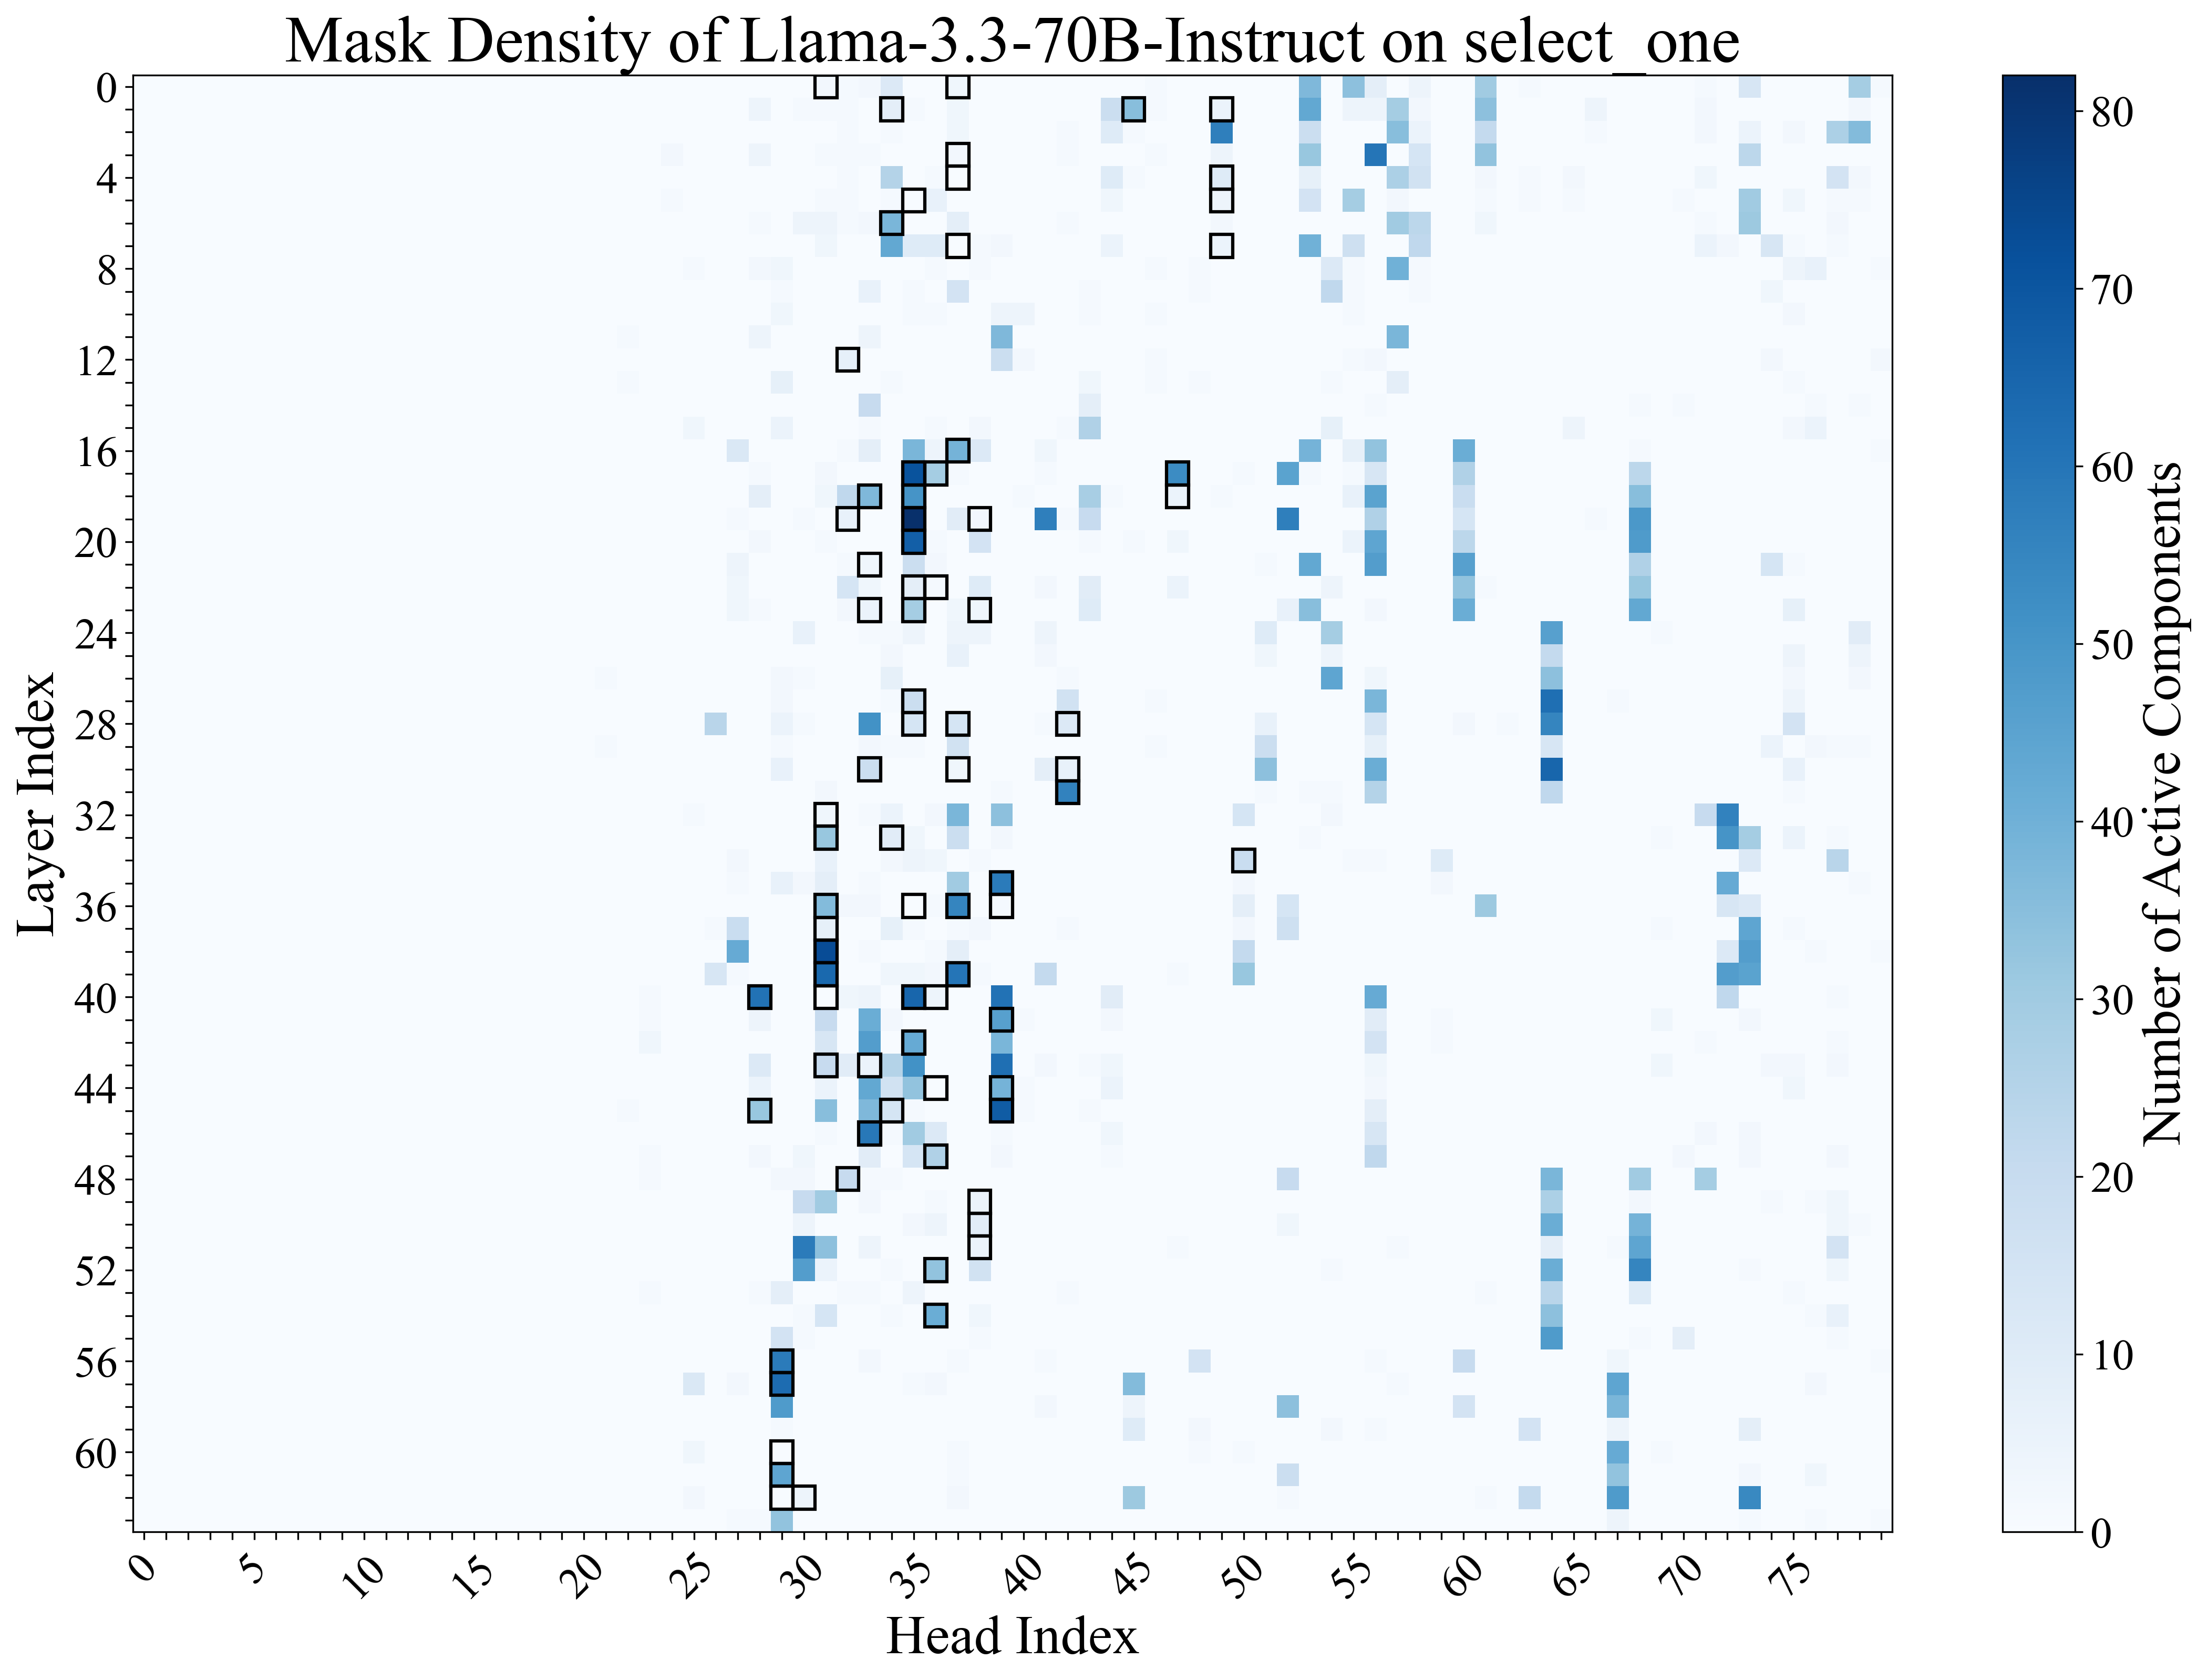

In [83]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches


plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.figure(figsize=(18, 12))
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

n_heads = mt.config.num_attention_heads
n_layer = mt.n_layer
mask_density = torch.zeros((n_heads, n_layer), dtype=torch.float32)

for (layer_idx, head_idx), mask in loaded_opt_results["masks"].items():
    mask_density[head_idx, layer_idx] = mask.sum().item()


def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret


# plt.figure(figsize=(12, 6))
plt.imshow(mask_density.cpu(), cmap="Blues", aspect="auto")
plt.colorbar(label="Number of Active Components")
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title(f"Mask Density of {mt.name.split('/')[-1]} on {select_task.task_name}")
plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_heads),
    labels=get_ticks(range(n_heads), skip=4),
)

ax = plt.gca()
# Draw borders around marked cells
for x, y in optimized_heads:
    print(x, y)
    # Create a Rectangle patch
    # Note: (x-0.5, y-0.5) positions the rectangle correctly around the cell
    # Width and height of 1 covers exactly one cell
    rect = patches.Rectangle(
        (x - 0.5, y - 0.5),  # bottom-left corner
        1,  # width
        1,  # height
        linewidth=1.5,  # border thickness
        edgecolor="black",  # border color (you can change this)
        facecolor="none",  # no fill, just border
    )
    ax.add_patch(rect)  # FIXED: This should be inside the loop!

plt.show()

## Validation

In [84]:
masks = loaded_opt_results["masks"]
zero_proj_heads = []
for (layer_idx, head_idx), mask in masks.items():
    # if (
    #     mask.sum().item()
    #     == 0
    #     or layer_idx >= 52
    # ):
    if (layer_idx, head_idx) not in optimized_heads:
        zero_proj_heads.append((layer_idx, head_idx))

len(zero_proj_heads)

5041

In [85]:
selected_heads = [
    (layer_idx, head_idx, mask.sum().item())
    for (layer_idx, head_idx), mask in masks.items()
    if (layer_idx, head_idx) not in zero_proj_heads
]

selected_heads.sort(key=lambda x: (x[2], x[0], x[1]), reverse=True)
selected_heads[:10]

[(35, 19, 82.0),
 (31, 38, 73.0),
 (35, 17, 71.0),
 (39, 45, 68.0),
 (35, 20, 67.0),
 (35, 40, 65.0),
 (31, 39, 64.0),
 (29, 57, 63.0),
 (28, 40, 61.0),
 (37, 39, 60.0)]

In [86]:
len(selected_heads)

79

In [88]:
validate_with_svds = {
    (layer_idx, head_idx): svd_per_head[(layer_idx, head_idx)]
    for layer_idx, head_idx, _ in selected_heads
}

len(validate_with_svds)

79

In [89]:
from src.functional import interpret_logits
from src.selection.data import get_first_token_id, get_options_for_answer

destination_sample, source_sample = validation_set[20]
print("Source:", source_sample.prompt(), ">>", source_sample.obj)
print("Destination:", destination_sample.prompt(), ">>", destination_sample.obj)
print(
    f"target: {destination_sample.metadata['track_type_obj']} | \"{mt.tokenizer.decode(destination_sample.metadata['track_type_obj_token_id'])}\""
)

ret_dict = validate_low_rank_qk_svd_bases_on_sample_pair(
    mt=mt,
    source_sample=source_sample,
    destination_sample=destination_sample,
    svd_per_head=validate_with_svds,
    masks={
        key: masks[key] for key in validate_with_svds.keys()
    },
    token_mapping={-1: -1},
    must_track_tokens=[],
    return_clean_predictions=True,
    debug=True,
)

Source: Options: Will Smith, Anderson Cooper, Warren Buffett, Damian Lillard, Canelo Álvarez.
Who among these people mentioned above is a news anchor by profession?
Answer: >> Anderson Cooper
Destination: Options: Anthony Davis, Tyreek Hill, Spike Lee, Norah O'Donnell, Sergey Brin.
Who among these people mentioned above is a entrepreneur by profession?
Answer: >> Sergey Brin
target: Norah O'Donnell | " Nor"
Destination: Options: Paul Thomas Anderson, Bo Burnham, Colleen Hoover.
Who among these people mentioned above is a comedian by profession?
Answer: >> Ans:  Sergey
2025-10-25 21:22:43 src.selection.functional DEBUG    Predictions: ['" Sergey"[74529] (p=0.926, logit=22.125)', '" The"[578] (p=0.025, logit=18.500)', '" Among"[22395] (p=0.012, logit=17.750)', '" ("[320] (p=0.009, logit=17.500)', '" Spike"[61352] (p=0.008, logit=17.375)']
2025-10-25 21:22:43 src.selection.functional INFO     Combined attention matrix for all heads


Source: Options: Neymar, Ellen DeGeneres, Clint Eastwood.
Who among these people mentioned above is a director by profession?
Answer: >> Ans:  Anderson
2025-10-25 21:22:43 src.selection.functional DEBUG    Predictions: ['" Anderson"[21293] (p=0.906, logit=23.500)', '" The"[578] (p=0.045, logit=20.500)', '" Among"[22395] (p=0.027, logit=20.000)', '" ("[320] (p=0.005, logit=18.375)', '" News"[5513] (p=0.003, logit=17.875)']
2025-10-25 21:22:43 src.selection.functional INFO     Combined attention matrix for all heads


attentions.shape=torch.Size([80, 1, 64, 38, 38])


2025-10-25 21:22:44 __main__ DEBUG    ----------------------------------------------------------------------------------------------------
2025-10-25 21:22:44 __main__ DEBUG    target: Norah O'Donnell | " Nor"
2025-10-25 21:22:44 __main__ DEBUG    Patched pred : ['" Nor"[8170] (p=0.918, logit=21.250)', '" The"[578] (p=0.022, logit=17.500)', '" ("[320] (p=0.017, logit=17.250)', '" Among"[22395] (p=0.015, logit=17.125)', '" Anthony"[21353] (p=0.003, logit=15.625)']
2025-10-25 21:22:44 __main__ DEBUG    Patched track: ['" Nor"[8170] (p=0.918, logit=21.250)', '" Anthony"[21353] (p=0.003, logit=15.625)', '" Ty"[14221] (p=0.003, logit=15.500)', '" Sergey"[74529] (p=0.000, logit=13.188)', '" Spike"[61352] (p=0.000, logit=11.688)', '" Anderson"[21293] (p=0.000, logit=9.188)']
2025-10-25 21:22:44 __main__ DEBUG    ----------------------------------------------------------------------------------------------------


In [90]:
from tqdm.auto import tqdm

validation_results = []
for destination, source in tqdm(validation_set):
    # destination = copy.deepcopy(destination)
    # source = copy.deepcopy(source)
    # destination.default_option_style = "bulleted"
    # source.prompt_template = select_task.prompt_templates[2]
    # destination.prompt_template = select_task.prompt_templates[2]

    # source_tokenized = prepare_input(prompts=[source.prompt()], tokenizer=mt)
    # destination_tokenized = prepare_input(prompts=[destination.prompt()], tokenizer=mt)

    track_tokens = {
        "clean_obj": destination.ans_token_id,
        "corrupt_obj": source.ans_token_id,
        "target_obj": destination.metadata["track_type_obj_token_id"],
    }

    pair_result = validate_low_rank_qk_svd_bases_on_sample_pair(
        mt=mt,
        destination_sample=destination,
        source_sample=source,
        svd_per_head=validate_with_svds,
        masks={key: masks[key] for key in validate_with_svds.keys()},
        token_mapping={-1: -1},
        must_track_tokens=list(track_tokens.values()),
        return_clean_predictions=True,
        debug=False,
    )
    das_patched_pred = pair_result["patched_predictions"]
    das_patched_track = pair_result["patched_track"]
    destination_pred = pair_result["destination_predictions"]
    destination_track = pair_result["destination_track"]

    validation_results.append(
        {
            "destination": destination,
            "source": source,
            "patched_pred": das_patched_pred,
            "patched_track": das_patched_track,
            "destination_pred": destination_pred,
            "destination_track": destination_track,
            "track_tokens": track_tokens,
        }
    )

  0%|          | 0/512 [00:00<?, ?it/s]

In [91]:
import numpy as np

track_token_types = ["clean_obj", "target_obj"]

for token_type in track_token_types:
    print(f"{token_type}")
    ranks = {"clean": [], "patch": []}
    logits = {"clean": [], "patch": []}
    for result in validation_results:
        target_tok_id = result["track_tokens"][token_type]
        clean_rank, clean_pred = result["destination_track"][target_tok_id]
        patch_rank, patch_pred = result["patched_track"][target_tok_id]
        ranks["clean"].append(clean_rank)
        ranks["patch"].append(patch_rank)
        logits["clean"].append(clean_pred.logit)
        logits["patch"].append(patch_pred.logit)

    attr = {
        "rank": ranks,
        "logit": logits,
    }
    for key in attr:
        clean = np.array(attr[key]["clean"])
        patch = np.array(attr[key]["patch"])
        delta = patch - clean
        print(
            f"{key}: clean {clean.mean():.2f} ± {clean.std():.2f} -> patch {patch.mean():.2f} ± {patch.std():.2f} | delta {delta.mean():.2f} ± {delta.std():.2f}"
        )


top_1_accuracy = 0
failed_cases = []
for result in validation_results:
    target_tok_id = result["destination"].metadata["track_type_obj_token_id"]
    patched_track = result["patched_track"]
    if patched_track[list(patched_track.keys())[0]][1].token_id == target_tok_id:
        top_1_accuracy += 1

    else:
        failed_cases.append(result)

causality = top_1_accuracy / len(validation_results)
print(f"causality: {causality: .4f} ({top_1_accuracy}/{len(validation_results)})")

clean_obj
rank: clean 1.00 ± 0.04 -> patch 158.33 ± 301.63 | delta 157.33 ± 301.63
logit: clean 22.25 ± 0.72 -> patch 12.47 ± 3.16 | delta -9.78 ± 3.25
target_obj
rank: clean 64.75 ± 174.35 -> patch 3.89 ± 17.22 | delta -60.86 ± 175.59
logit: clean 13.81 ± 2.41 -> patch 19.90 ± 2.22 | delta 6.09 ± 3.32
causality:  0.7520 (385/512)


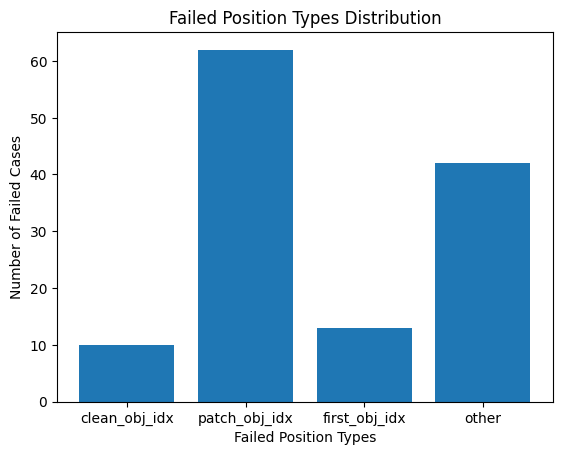

: 

In [ ]:
#! find the positions after the patched intervention.
# Is it looking at the first one, or the position of the
# previous answer?

from src.functional import is_nontrivial_prefix

failed_pos_track = {
    "clean_obj_idx": [],
    "patch_obj_idx": [],
    "first_obj_idx": [],
    "other": [],
}

for failed_case in failed_cases:
    destination = failed_case["destination"]
    source = failed_case["source"]
    int_track = failed_case["patched_track"]
    clean_track = failed_case["destination_track"]
    clean_obj_idx = destination.obj_idx
    patch_obj_idx = source.obj_idx

    int_top_tok = list(int_track.keys())[0]
    int_top_tok = int_track[int_top_tok][1].token.strip()
    int_top_obj = None
    for opt in destination.options:
        if is_nontrivial_prefix(int_top_tok, opt):
            int_top_obj = opt
            break
    int_top_idx = destination.options.index(int_top_obj)

    if int_top_idx == clean_obj_idx:
        failed_pos_track["clean_obj_idx"].append(failed_case)
    elif int_top_idx == patch_obj_idx:
        failed_pos_track["patch_obj_idx"].append(failed_case)
    elif int_top_idx == 0:
        failed_pos_track["first_obj_idx"].append(failed_case)
    else:
        failed_pos_track["other"].append(failed_case)


from matplotlib import pyplot as plt

plt.rcdefaults()
x_vals = failed_pos_track.keys()
y_vals = [len(failed_pos_track[key]) for key in x_vals]
plt.bar(x_vals, y_vals)
plt.xlabel("Failed Position Types")
plt.ylabel("Number of Failed Cases")
plt.title("Failed Position Types Distribution")
plt.show()